In [1]:
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

In [14]:
#NEW DATA TEST
caiso=pd.read_csv("/Users/john_schafer/Downloads/CE291/Final_Project/CAISO_zone_1_.csv")

In [15]:
#Transform Data to our format
caiso['time'] = pd.to_datetime(caiso['time'])
caiso.set_index('time', inplace=True)

# Function to reshape the data
def reshape_data(df, column):
    # Resample data to daily frequency, and apply list to convert each day's data into a list
    daily_data = df[column].resample('D').apply(list)
    # Convert lists to a DataFrame, which inherently transposes the list to columns
    return pd.DataFrame(daily_data.tolist(), index=daily_data.index)

# Creating each DataFrame
demand_df = reshape_data(caiso, 'load_power')
solar_df = reshape_data(caiso, 'solar_power')
wind_df = reshape_data(caiso, 'wind_power')

def rename_columns(df):
    num_minutes = df.shape[1]
    time_labels = [str(pd.Timedelta(minutes=i)) for i in range(num_minutes)]
    df.columns = time_labels
    return df

demand_df = rename_columns(demand_df)
solar_df = rename_columns(solar_df)
wind_df = rename_columns(wind_df)

In [16]:

#Scaling 
# if power is normalized to 1, PEV dynamics in environment are run in kw
#max power of single Ev = 11 kw 
#max power of representative small microgrid of 5,000 people ~ 3.5 megawatts=3,500 kw
#multiply vby 3500 to get representative 
demand_caiso = np.array(demand_df)
solar_caiso = np.array(solar_df)*3 
wind_caiso = np.array(wind_df)*4 
net_caiso=demand_caiso-solar_caiso-wind_caiso

average_demand_per_minute = np.nanmean(demand_caiso, axis=0)
average_solar_per_minute = np.nanmean(solar_caiso, axis=0)
average_wind_per_minute = np.nanmean(wind_caiso, axis=0)

average_net_per_minute=average_demand_per_minute-average_solar_per_minute-average_wind_per_minute

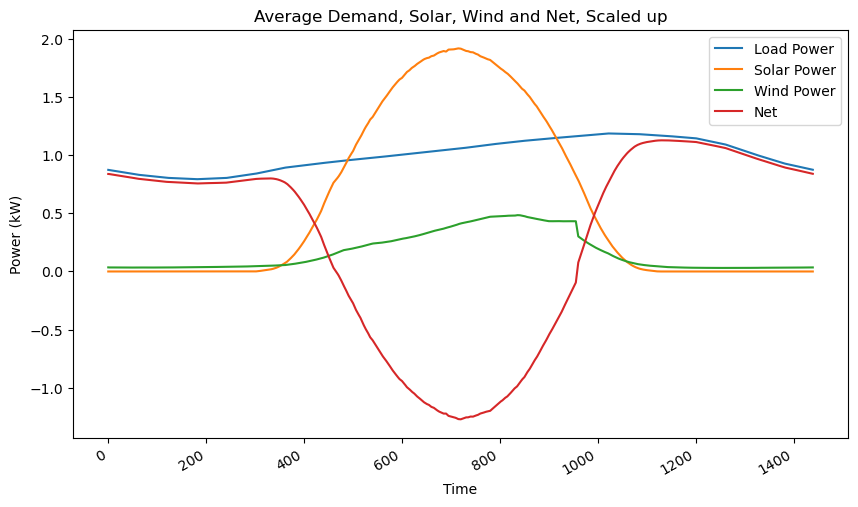

In [17]:
timestep_length=1 #in minutes
T=1440 # minutes in 24hrs

time_steps = np.arange(0, T * timestep_length, timestep_length)  # Generate a time axis\
plt.figure(figsize=(10, 6))
plt.plot(time_steps, average_demand_per_minute, label='Load Power')
plt.plot(time_steps, average_solar_per_minute, label='Solar Power')
plt.plot(time_steps, average_wind_per_minute, label='Wind Power')
plt.plot(time_steps, average_net_per_minute, label='Net')

# Adding titles and labels
plt.title('Average Demand, Solar, Wind and Net, Scaled up')
plt.xlabel('Time')
plt.ylabel('Power (kW)')
plt.legend()

# Rotating date labels for better visibility
plt.gcf().autofmt_xdate()

plt.show()

In [18]:
from DQL_RNN import DQNAgent
from env_rnn import GridEnvironment

In [19]:
average_demand_per_minute= average_demand_per_minute.reshape(1440,1).T
average_solar_per_minute=average_solar_per_minute.reshape(1440,1).T
average_wind_per_minute=average_wind_per_minute.reshape(1440,1).T


#Attempting to round: 
average_demand_per_minute_rd=np.round(average_demand_per_minute*100)/100 #Rounds each entry to nearest .1!
average_solar_per_minute_rd=np.round(average_solar_per_minute*100)/100
average_wind_per_minute_rd=np.round(average_wind_per_minute*100)/100

In [20]:
#testing over same "average" episode
#testing with simple RNN
#testing with rounded, "binned" energy profiles
import time
timestep_length=(1/60) #in hours
N=10
sequence_length=120 #In timesteps aka minutes
state_deque = deque(maxlen=sequence_length)

day_index=0
# Initialize DQN agent
agent = DQNAgent(state_size=14, action_size=(3**N), sequence_length=sequence_length)

episode_durations = []

for episode in range(10):  # Loop over 3 episodes of same "average" day
    # Initialize environment for the current day
    start_time = time.time()
    env = GridEnvironment(N, average_demand_per_minute_rd, average_solar_per_minute_rd, average_wind_per_minute_rd, day_index, timestep_length)
    
    total_reward = 0
    T = 1440  # Assume T timesteps in a day

    demand_profile = np.zeros(T)
    solar_profile = np.zeros(T)
    wind_profile = np.zeros(T)
    PEV_profile = np.zeros(T)

    for timestep in range(1, T+1):  # Loop through each timestep in the day
        normalized_timestep = np.array([timestep / T])   # T is the total number of timesteps in a day

        current_demand, current_solar, current_wind = env.get_state()
        current_P_EV=env.P_EV
        current_state=np.concatenate([np.array([current_demand, current_solar, current_wind]), np.array(current_P_EV), normalized_timestep])

        state_deque.append(current_state)
        state_history = np.array(state_deque)

        if len(state_deque) < sequence_length:
            continue  # Wait until deque is full before starting training
        
        action = agent.act(state_history)  # Decide action based on current state

        # Execute action in the environment and observe the next state, reward, and done flag
        reward, done, next_demand, next_solar, next_wind, next_P_EV = env.step(action)

        # Update profiles for plotting
        demand_profile[timestep - 1] = next_demand
        solar_profile[timestep - 1] = next_solar
        wind_profile[timestep - 1] = next_wind
        PEV_profile[timestep - 1] = np.sum(next_P_EV)
        
        normalized_next_timestep = np.array([(timestep+1) / T])
        # Construct the new state from the separated components
        next_state = np.concatenate([np.array([next_demand, next_solar, next_wind]), np.array(next_P_EV), normalized_next_timestep])
        
        # Directly learn from this transition without using replay
        agent.learn(state_history, action, reward, next_state, done)

        # Update state and total_reward
        #state = next_state why did I have this?
        total_reward += reward
        

        if done:
            # Handle episode completion, if applicable
            break

    print(f"Total reward for day {day_index}: {total_reward}")
    episode_durations.append(time.time() - start_time)
print("Individual episode durations:", episode_durations)



Total reward for day 0: -1049.8607448638536
Total reward for day 0: -1167.5671329751676
Total reward for day 0: -1210.3334815229637
Total reward for day 0: -1088.8229673517735
Total reward for day 0: -1241.9555972202404
Total reward for day 0: -1191.6583539432531
Total reward for day 0: -1175.9181546590628
Total reward for day 0: -1204.5762156519088
Total reward for day 0: -1127.589155569905
Total reward for day 0: -1280.5469245105862
Individual episode durations: [151.99898409843445, 161.87306594848633, 169.70676183700562, 163.55347394943237, 163.45062017440796, 163.7341170310974, 162.20809888839722, 473.808002948761, 468.81327199935913, 189.74191880226135]


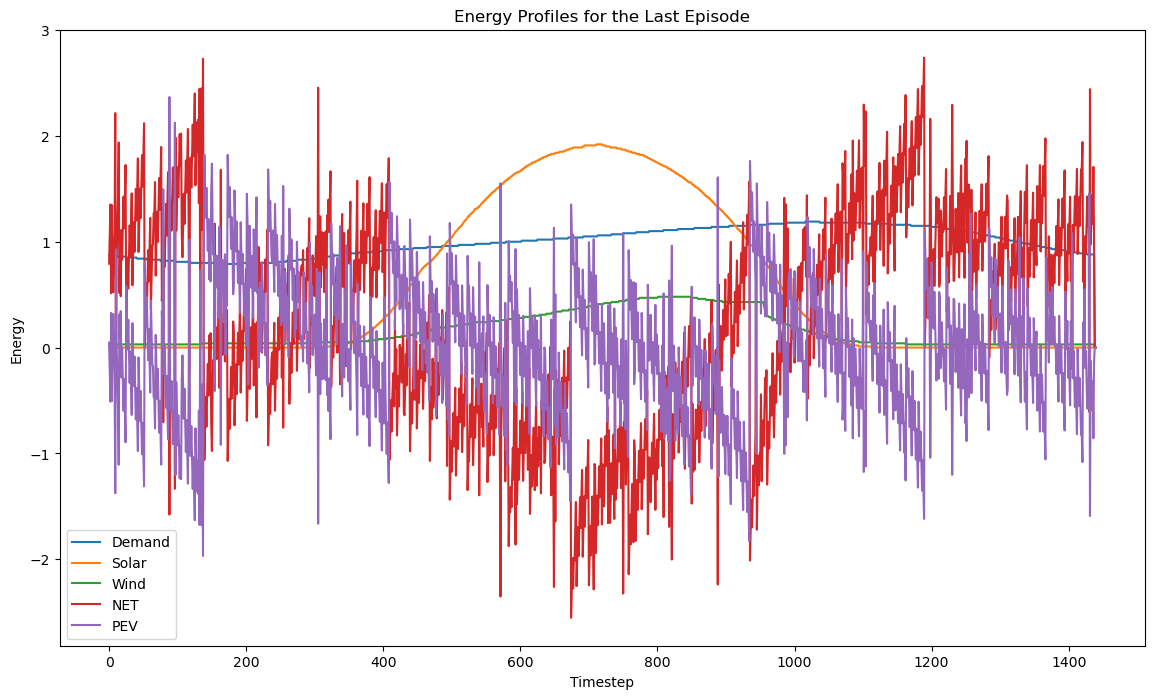

In [21]:
plt.figure(figsize=(14, 8))
plt.plot(demand_profile, label='Demand')
plt.plot(solar_profile, label='Solar')
plt.plot(wind_profile, label='Wind')
plt.plot(demand_profile-solar_profile- wind_profile-PEV_profile, label='NET')
plt.plot(PEV_profile, label='PEV')
plt.legend()
plt.title('Energy Profiles for the Last Episode')
plt.xlabel('Timestep')
plt.ylabel('Energy')
plt.show()

In [ ]:
#USING AGENT W RNN ONE EPISODE
#also experimenting with adding time as a state

day_index=563 #random
timestep_length= (1/60) #in hours
N=10

sequence_length=120 #how far back LSTM looks back
state_deque = deque(maxlen=sequence_length)

env = GridEnvironment(N, demand_caiso, solar_caiso, wind_caiso, day_index, timestep_length)
agent = DQNAgent(state_size=env.state_size, action_size=env.action_size, sequence_length=sequence_length)

# Run for one episode (one day)
state = env.get_state()  # Reset environment to start state
total_reward = 0

T=1440 #(15 minute steps in 24 hrs)

demand_profile = np.zeros(T)
solar_profile = np.zeros(T)
wind_profile = np.zeros(T)
PEV_profile = np.zeros(T)

for timestep in range(1, T+1):  # Assume T timesteps in a day

    normalized_timestep = np.array([timestep / T])   # T is the total number of timesteps in a day

    current_demand, current_solar, current_wind = env.get_state()
    current_P_EV=env.P_EV
    current_state=np.concatenate([np.array([current_demand, current_solar, current_wind]), np.array(current_P_EV), normalized_timestep])

    state_deque.append(current_state)
    state_history = np.array(state_deque)

    if len(state_deque) < sequence_length:
        continue  # Wait until deque is full before starting training
    

    action = agent.act(state_history)  # Decide action based on current state

    # Execute action in the environment and observe the next state, reward, and done flag
    reward, done, next_demand, next_solar, next_wind, next_P_EV = env.step(action)


    # Update profiles for plotting
    demand_profile[timestep - 1] = next_demand
    solar_profile[timestep - 1] = next_solar
    wind_profile[timestep - 1] = next_wind
    PEV_profile[timestep - 1] = np.sum(next_P_EV)
    
    normalized_next_timestep = np.array([(timestep+1) / T])
    # Construct the new state from the separated components
    next_state = np.concatenate([np.array([next_demand, next_solar, next_wind]), np.array(next_P_EV), normalized_next_timestep])
    
    # Directly learn from this transition without using replay
    agent.learn(state_history, action, reward, next_state, done)

    # Update state and total_reward
    #state = next_state why did I have this?
    total_reward += reward
    

    if done:
        # Handle episode completion, if applicable
        break

print("Total reward for the episode (day):", total_reward)


In [ ]:
#PLOT 1 Episode Test W/ LSTM
time_steps = np.arange(0, T, 1)  # Generate a time axis

plt.figure(figsize=(14, 14))  # Increase the figure size to accommodate two subplots

# First subplot for individual profiles
plt.subplot(2, 1, 1)  # (rows, columns, panel number)
plt.plot(time_steps, demand_profile, label='Demand', color='black')
plt.plot(time_steps, solar_profile, label='Solar', color='orange')
plt.plot(time_steps, wind_profile, label='Wind', color='blue')
plt.plot(time_steps, PEV_profile, label='Sum of P_EV', color='green')
plt.xlabel('Time (hours)')
plt.ylabel('Energy (units)')
plt.title('Individual Energy Profiles for One Day')
plt.legend()
plt.grid(True)

# Second subplot for net demand
plt.subplot(2, 1, 2)  # (rows, columns, panel number)
net_demand_profile = demand_profile - solar_profile - wind_profile-PEV_profile
plt.plot(time_steps, net_demand_profile, label='Net Demand', color='red')
plt.xlabel('Time (hours)')
plt.ylabel('Net Energy (units)')
plt.title('Net Energy Profile for One Day')
plt.legend()
plt.grid(True)

# Show both plots
plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure
plt.show()